In [2]:
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
from math import acos, sqrt
import warnings

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

from IPython.core.display import HTML; css_file = '../2019/style.css'; HTML(open(css_file, "r").read())

# MS²PIP 2023 manuscript - Figures

This notebook contains the generation of the figures for the MS²PIP 2022 manuscript:


The notebook requires the following files:


The notebook was run in Python 3.8.13 with the following packages:

ipython==8.4.0\
numpy==1.23.0\
pandas==1.4.3\
matplotlib==3.5.2\
seaborn==0.11.2

## Functions

In [3]:
def ms2pip_pearson(true, pred):
    """
    Return pearson of tic-normalized, log-transformed intensities, 
    the MS2PIP way.
    """
    #tic_norm = lambda x: x / np.sum(x)
    # log_transform = lambda x: np.log2(x + 0.001)
    corr = pearsonr(
        true, 
        pred
    )[0]
    return (corr)


def spectral_angle(true, pred, epsilon=1e-7):
    """
    Return square root normalized spectral angle.
    See https://doi.org/10.1074/mcp.O113.036475
    """
    
    de_log = lambda x: (2**x)-0.001
    l2_normalize = lambda x: x / sqrt(max(sum(x**2), epsilon))
    
    pred_norm = l2_normalize(de_log(pred))
    true_norm = l2_normalize(de_log(true))
    
    spectral_angle = 1 - (2 * acos(np.dot(pred_norm, true_norm)) / np.pi)

    return (spectral_angle)

def data_loading(filename, filename_mapper):
    ms2pip_models = {
        "_HCD2019_": "2019 HCD",
        "_Immuno-HCD_": "Immuno HCD",
        "_CID_": "CID",
        "_CID-TMT": "CID-TMT",
        "_HCD2021_": "2021 HCD",
        "_TMT_": "TMT"
    }

    test_df = pd.read_csv("/home/arthur/ms2pip-nar-manuscript/" + filename)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        df = test_df.groupby(["spec_id"]).agg({"prediction": list, "target": list}).reset_index()
        df["pearson"] = df.apply(lambda x: ms2pip_pearson(x.target, x.prediction), axis=1)
        df["SA"] = df.apply(lambda x: spectral_angle(np.array(x.target), np.array(x.prediction)), axis=1)
        df["data"] = filename_mapper[filename]
        for model_name, model in ms2pip_models.items():
            if model_name in filename:
                ms2pip_model = model
        df["model"] = ms2pip_model

        return df[["spec_id", "pearson", "SA", "data", "model"]]


## Loading the prediction files

In [4]:
data_set_map = {
    "HCD_PXD008034_Ecoli_HCD2021_pred_and_emp.csv": "tryptic",
    "HCD_PXD008034_Ecoli_HCD2019_pred_and_emp.csv": "tryptic",
    "HCD_PXD008034_Ecoli_Immuno-HCD_pred_and_emp.csv": "tryptic",
    "spec_lib_PXD005231_HCD2019_pred_and_emp.csv": "HLA-I",
    "spec_lib_PXD005231_HCD2021_pred_and_emp.csv": "HLA-I",
    "spec_lib_PXD005231_Immuno-HCD_pred_and_emp.csv": "HLA-I",
    "spec_lib_pxd020011_Immuno-HCD_pred_and_emp.csv": "HLA-II",
    "spec_lib_pxd020011_HCD2019_pred_and_emp.csv": "HLA-II",
    "spec_lib_pxd020011_HCD2021_pred_and_emp.csv": "HLA-II",
    "test_spec_lib_PXD010154_HCD2021_pred_and_emp.csv": "Chymotrypsin",
    "test_spec_lib_PXD010154_HCD2019_pred_and_emp.csv": "Chymotrypsin",
    "test_spec_lib_PXD010154_Immuno-HCD_pred_and_emp.csv": "Chymotrypsin"}

cid_tmt_map = {
        "spec_lib_pxd00589_CID-TMT_pred_and_emp.csv": "CID-TMT",
        "spec_lib_pxd00589_CID_pred_and_emp.csv": "CID-TMT",
        "spec_lib_pxd00589_TMT_pred_and_emp.csv": "CID-TMT",
        # "spec_lib_pxd00589_HCD2021_pred_and_emp.csv": "CID-TMT"
}

In [5]:
non_tryptic_correlations = pd.concat([data_loading(file, data_set_map) for file in data_set_map.keys()])
non_tryptic_correlations['data'] = pd.Categorical(non_tryptic_correlations['data'],
                                   categories=['tryptic', 'Chymotrypsin', 'HLA-I', 'HLA-II'],
                                   ordered=True)
cid_tmt_correlations = pd.concat([data_loading(file, cid_tmt_map) for file in cid_tmt_map.keys()])

In [6]:
peprec_pxd010154 = pd.read_table("/home/arthur/ms2pip-nar-manuscript/test_spec_lib_PXD010154.peprec", sep=" ")

# Figure 1: Boxplots for novel tryptic models 

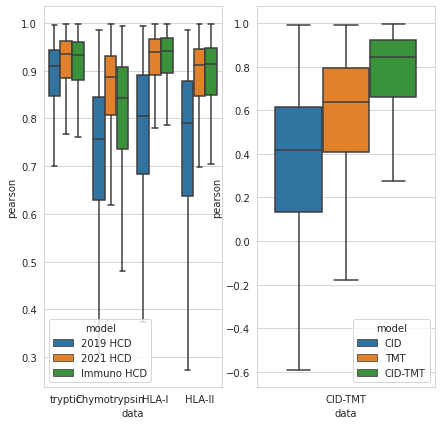

In [8]:
fig = plt.Figure(figsize=(7,7))
ax1 = fig.add_subplot(121)
sns.boxplot(
    data=non_tryptic_correlations,
    x="data",
    y="pearson",
    hue="model",
    showfliers= False,
    hue_order=["2019 HCD", "2021 HCD", "Immuno HCD"],
    ax=ax1
)
ax2 = fig.add_subplot(122)
sns.boxplot(
    data=cid_tmt_correlations,
    x="data",
    y="pearson",
    hue="model",
    showfliers= False,
    hue_order=[ "CID", "TMT", "CID-TMT"],
    ax=ax2
)

fig

In [ ]:
non_tryptic_correlations.groupby(["data", "model"]).agg({"pearson": "median", "spec_id": "count"})

pearson  spec_id
data         model                        
tryptic      2019 HCD    0.910123    35212
             2021 HCD    0.934454    35212
             Immuno HCD  0.932352    35212
Chymotrypsin 2019 HCD    0.756812    25798
             2021 HCD    0.886789    25570
             Immuno HCD  0.842392    25798
HLA-I        2019 HCD    0.805887    12534
             2021 HCD    0.939815    12534
             Immuno HCD  0.942002    12534
HLA-II       2019 HCD    0.791316    12745
             2021 HCD    0.911232    12745
             Immuno HCD  0.913439    12745

In [ ]:
cid_tmt_correlations.groupby(["data", "model"]).agg({"pearson": "median", "spec_id": "count"})

pearson  spec_id
data    model                     
CID-TMT CID      0.417447    69768
        CID-TMT  0.844415    69768
        TMT      0.639954    69768

## Figure: chymotrypsin predictions based on length

In [ ]:
chymotrypsin = non_tryptic_correlations[non_tryptic_correlations["data"] == "Chymotrypsin"]
chymotrypsin["length"] = chymotrypsin["spec_id"].map(dict(zip(peprec_pxd010154["spec_id"], peprec_pxd010154["peptide"].apply(len))))


/tmp/ipykernel_746454/1639554126.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chymotrypsin["length"] = chymotrypsin["spec_id"].map(dict(zip(peprec_pxd010154["spec_id"], peprec_pxd010154["peptide"].apply(len))))


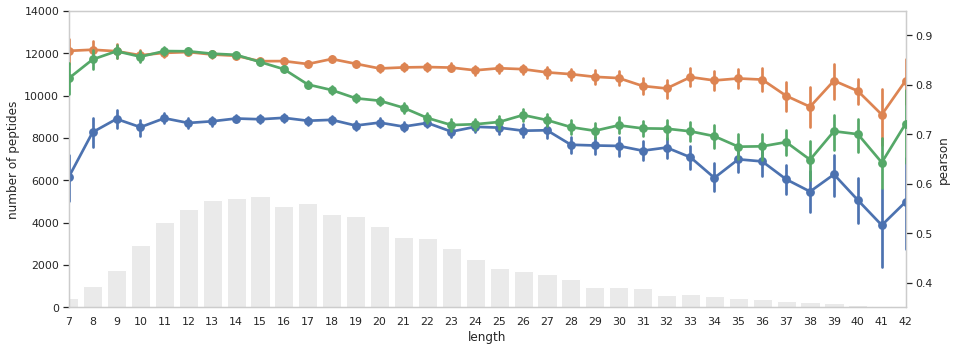

In [ ]:
fig = plt.figure()
sns.set(style="whitegrid")

fig.add_subplot(211)

ax = sns.countplot(
x="length",
data=chymotrypsin,
color="#EAEAEA")
ax.axes.set_ylabel("number of peptides")
ax.axes.set_ylim([0,14000])
ax.grid(False)
ax2=ax.twinx()
ax2 = sns.pointplot(
x="length",
y="pearson",
hue="model",
hue_order=["2019 HCD", "2021 HCD", "Immuno HCD"],
showfliers=False,
data=chymotrypsin,
legend= False)
ax2.grid(False)
ax2.axes.set_ylim([0.35,0.95])
ax2.set_xlim(0,35)
ax2.legend(bbox_to_anchor=(.40, 0.30), frameon=True)
ax2.get_legend().remove()
fig.set_size_inches(15, 12)
#plt.savefig("data/Figures/FigureS1A.svg")
plt.show()